<a href="https://colab.research.google.com/gist/cordmaur/fb87e10554cfd28e21c4adf69dfcd6e7/earthsurfacewater_medium_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment

In [1]:
!wget https://zenodo.org/record/5205674/files/dset-s2.zip

--2022-12-12 07:52:05--  https://zenodo.org/record/5205674/files/dset-s2.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611792578 (583M) [application/octet-stream]
Saving to: ‘dset-s2.zip’

dset-s2.zip         100%[===================>] 583.45M  7.76MB/s    in 13m 31s 

2022-12-12 08:05:39 (737 KB/s) - ‘dset-s2.zip’ saved [611792578/611792578]



In [2]:
!unzip dset-s2.zip

Archive:  dset-s2.zip
   creating: dset-s2/
  inflating: __MACOSX/._dset-s2      
   creating: dset-s2/tra_truth/
   creating: dset-s2/val_truth/
   creating: dset-s2/tra_scene/
   creating: dset-s2/val_scene/
  inflating: dset-s2/tra_truth/S2A_L2A_20190817_N0213_R089_S1_Truth.tif  
  inflating: dset-s2/tra_truth/S2B_L2A_20190818_N0213_R035_S1_Truth.tif  
  inflating: dset-s2/tra_truth/S2A_L2A_20190716_N0213_R063_S3_Truth.tif  
  inflating: dset-s2/tra_truth/S2A_L2A_20190314_N0211_R008_S1_Truth.tif  
  inflating: dset-s2/tra_truth/S2B_L2A_20190807_N0213_R018_S2_Truth.tif  
  inflating: dset-s2/tra_truth/S2B_L2A_20190904_N0213_R132_S2_Truth.tif  
  inflating: dset-s2/tra_truth/S2A_L2A_20190811_N0213_R013_S2_Truth.tif  
  inflating: dset-s2/tra_truth/S2B_L2A_20190506_N0212_R126_S3_Truth.tif  
  inflating: dset-s2/tra_truth/S2A_L2A_20190206_N0211_R067_S1_Truth.tif  
  inflating: dset-s2/tra_truth/S2A_L2A_20190125_N0211_R034_S1_Truth.tif  
  inflating: dset-s2/tra_truth/S2B_L2A_20191023_N0

In [3]:
%pip install rasterio -q
%pip install torchgeo -q

     |████████████████████████████████| 20.9 MB 1.8 MB/s 
     |████████████████████████████████| 279 kB 9.6 MB/s 
     |████████████████████████████████| 419 kB 60.3 MB/s 
     |████████████████████████████████| 19.1 MB 28 kB/s 
     |████████████████████████████████| 551 kB 72.7 MB/s 
     |████████████████████████████████| 376 kB 78.0 MB/s 
     |████████████████████████████████| 1.0 MB 79.0 MB/s 
     |████████████████████████████████| 7.8 MB 42.9 MB/s 
     |████████████████████████████████| 800 kB 77.0 MB/s 
     |████████████████████████████████| 9.4 MB 46.2 MB/s 
     |████████████████████████████████| 79 kB 8.4 MB/s 
     |████████████████████████████████| 102 kB 12.5 MB/s 
     |████████████████████████████████| 16.6 MB 51.5 MB/s 
     |████████████████████████████████| 295 kB 55.8 MB/s 
     |████████████████████████████████| 965 kB 64.7 MB/s 
     |████████████████████████████████| 117 kB 53.6 MB/s 
     |████████████████████████████████| 125 kB 64.2 MB/s 
     |███████████

In [1]:
import logging
# this line is to avoid warnings from Rasterio to be printed on screen
# the warning is explained here: https://stackoverflow.com/questions/74089170/suppress-rasterio-warning-warning-1-tiffreaddirectory
logger = logging.getLogger("rasterio")
logger.setLevel(logging.ERROR)

## Creating the Datasets and DataLoaders

In [2]:
from pathlib import Path
from typing import Iterable, List
import matplotlib.pyplot as plt

import rasterio as rio

from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torch.utils.data import DataLoader
import torch

root = Path('dset-s2')
assert root.exists()

In [3]:
def scale(item: dict):
    item['image'] = item['image'] / 10000
    return item

In [4]:
train_imgs = RasterDataset(root=(root/'tra_scene').as_posix(), crs='epsg:3395', res=10, transforms=scale)
train_msks = RasterDataset(root=(root/'tra_truth').as_posix(), crs='epsg:3395', res=10)

valid_imgs = RasterDataset(root=(root/'val_scene').as_posix(), crs='epsg:3395', res=10, transforms=scale)
valid_msks = RasterDataset(root=(root/'val_truth').as_posix(), crs='epsg:3395', res=10)

# IMPORTANT
train_msks.is_image = False
valid_msks.is_image = False

train_dset = train_imgs & train_msks
valid_dset = valid_imgs & valid_msks

train_sampler = RandomGeoSampler(train_imgs, size=512, length=260, units=Units.PIXELS)
valid_sampler = RandomGeoSampler(valid_imgs, size=512, length=128, units=Units.PIXELS)


In [5]:
train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size=8, collate_fn=stack_samples)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size=8, collate_fn=stack_samples)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
train_batch.keys(), valid_batch.keys()

(dict_keys(['image', 'crs', 'bbox', 'mask']),
 dict_keys(['image', 'crs', 'bbox', 'mask']))

### Data Standardization and Spectral Indices

In [6]:
def calc_statistics(dset: RasterDataset):
        """
        Calculate the statistics (mean and std) for the entire dataset
        Warning: This is an approximation. The correct value should take into account the
        mean for the whole dataset for computing individual stds.
        For correctness I suggest checking: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
        """

        # To avoid loading the entire dataset in memory, we will loop through each img
        # The filenames will be retrieved from the dataset's rtree index
        files = [item.object for item in dset.index.intersection(dset.index.bounds, objects=True)]

        # Reseting statistics
        accum_mean = 0
        accum_std = 0

        for file in files:
            img = rio.open(file).read()/10000 #type: ignore
            accum_mean += img.reshape((img.shape[0], -1)).mean(axis=1)
            accum_std += img.reshape((img.shape[0], -1)).std(axis=1)

        # at the end, we shall have 2 vectors with lenght n=chnls
        # we will average them considering the number of images
        return accum_mean / len(files), accum_std / len(files)

In [7]:
class MyNormalize(torch.nn.Module):
    def __init__(self, mean: List[float], stdev: List[float]):
        super().__init__()

        self.mean = torch.Tensor(mean)[:, None, None]
        self.std = torch.Tensor(stdev)[:, None, None]

    def forward(self, inputs: dict):

        x = inputs["image"][..., : len(self.mean), :, :]

        # if batch
        if inputs["image"].ndim == 4:
            x = (x - self.mean[None, ...]) / self.std[None, ...]

        else:
            x = (x - self.mean) / self.std

        inputs["image"][..., : len(self.mean), :, :] = x

        return inputs

    def revert(self, inputs: dict):
        """
        De-normalize the batch.

        Args:
            inputs (dict): Dictionary with the 'image' key
        """

        x = inputs["image"][..., : len(self.mean), :, :]

        # if batch
        if x.ndim == 4:
            x = inputs["image"][:, : len(self.mean), ...]
            x = x * self.std[None, ...] + self.mean[None, ...]
        else:
            x = x * self.std + self.mean

        inputs["image"][..., : len(self.mean), :, :] = x

        return inputs


In [8]:
normalize = MyNormalize(*calc_statistics(train_imgs))

tfms = torch.nn.Sequential(
    indices.AppendNDWI(index_green=1, index_nir=3),
    indices.AppendNDWI(index_green=1, index_nir=5),
    indices.AppendNDVI(index_nir=3, index_red=2),
    normalize
)

## Batch Visualization

In [9]:
def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [2, 1, 0], bright: float = 3.):
    for img, ax in zip(images, axs):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.squeeze().numpy(), cmap='Blues')
        ax.axis('off')

def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5, chnls: List[int] = [2, 1, 0]):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())
    
    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))  

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright) #type: ignore

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) #type: ignore

    else:
      

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright) #type: ignore
    
        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)) #type: ignore

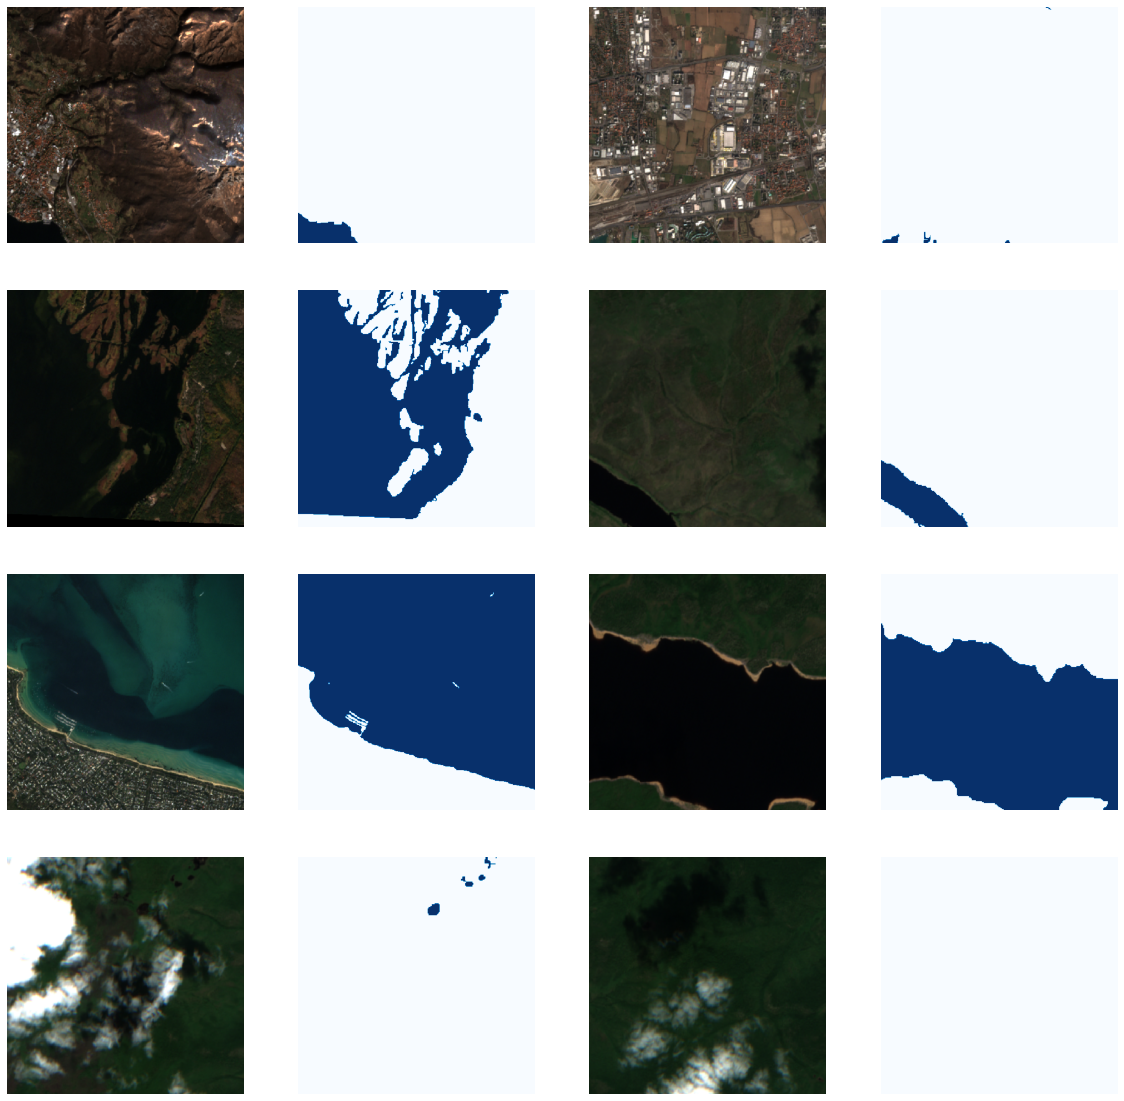

In [10]:
plot_batch(valid_batch)

In [15]:
valid_batch_tfmd = tfms(valid_batch)

In [16]:
valid_batch_tfmd['image'].shape

torch.Size([8, 9, 512, 512])